In [ ]:
import numpy as np
import pandas as pd
import datetime as dt

from sklearn.preprocessing import RobustScaler
import statistics
import math

from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
%ls

drive/  sample_data/


In [ ]:
test = pd.read_csv("/content/drive/MyDrive/7313Project/test_with_all.csv")
train = pd.read_csv("/content/drive/MyDrive/7313Project/train_with_all.csv")
testn = pd.read_csv("/content/drive/MyDrive/7313Project/test_with_all.csv")
target = pd.read_csv("/content/drive/MyDrive/7313Project/target.csv")

/usr/local/lib/python3.7/dist-packages/IPython/core/interactiveshell.py:2882: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [ ]:
train.drop(train.iloc[:, [0,1]], axis=1, inplace=True)
test.drop(test.iloc[:, [0,1]], axis=1, inplace=True)

In [ ]:
from sklearn.preprocessing import LabelEncoder
labelencoder = LabelEncoder()

In [ ]:
train['is_cup'] = labelencoder.fit_transform(train['is_cup'])
test['is_cup'] = labelencoder.fit_transform(test['is_cup'])
target['target'].replace({"home": 0, "draw": 1, "away":2}, inplace=True)
train.drop(train.filter(regex='recorded_matches').columns, axis=1, inplace = True)
test.drop(test.filter(regex='recorded_matches').columns, axis=1, inplace = True)
train_x = train.copy()
train_y = target['target'].copy()
train_x.fillna(train_x.mean(), inplace=True)
test.fillna(test.mean(), inplace=True)

In [ ]:
from sklearn.preprocessing import StandardScaler

#fit scaler on training data
norm = StandardScaler().fit(train_x)
#transform training data
xtrain_norm = norm.transform(train_x)
#transform testing data
test_norm = norm.transform(test)

In [ ]:
!pip install lightgbm

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    xtrain_norm, train_y, test_size=0.2, random_state=2, stratify=train_y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
import lightgbm as lgb
seed = 123
lgbm_params = {
    "objective":"multiclass",
    "boosting_type":"gbdt",
    'num_class':3,
    'metric': "multi_logloss",
    'learning_rate': 0.02,        
    'lambda_l1': .2,
    'lambda_l2': .8,
    'num_leaves': 400,
    'min_sum_hessian_in_leaf': 20,
    'feature_fraction': 0.5,
    'feature_fraction_bynode': 0.5,
    'bagging_fraction': 0.5,
    'bagging_freq': 42,
    'min_data_in_leaf': 700,
    'max_depth': 5,
    'seed': seed,
    'feature_fraction_seed': seed,
    'bagging_seed': seed,
    'drop_seed': seed,
    'data_random_seed': seed,
    'verbosity': -1
}

Training until validation scores don't improve for 100 rounds.
[100]	training's multi_logloss: 1.01619	valid_1's multi_logloss: 1.01982
[200]	training's multi_logloss: 1.00332	valid_1's multi_logloss: 1.01066
[300]	training's multi_logloss: 0.996656	valid_1's multi_logloss: 1.0074
[400]	training's multi_logloss: 0.991715	valid_1's multi_logloss: 1.00575
[500]	training's multi_logloss: 0.987444	valid_1's multi_logloss: 1.00471
[600]	training's multi_logloss: 0.983498	valid_1's multi_logloss: 1.00389
[700]	training's multi_logloss: 0.979773	valid_1's multi_logloss: 1.00347
[800]	training's multi_logloss: 0.976114	valid_1's multi_logloss: 1.00313
[900]	training's multi_logloss: 0.972544	valid_1's multi_logloss: 1.00284
[1000]	training's multi_logloss: 0.968954	valid_1's multi_logloss: 1.00278
Early stopping, best iteration is:
[967]	training's multi_logloss: 0.970199	valid_1's multi_logloss: 1.0027
0.5043266630611141
[[7646 3677 3521]
 [ 145  177  147]
 [1832 1676 3367]]
Training until va

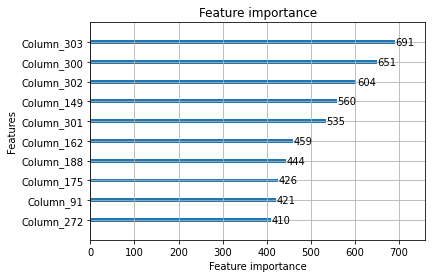

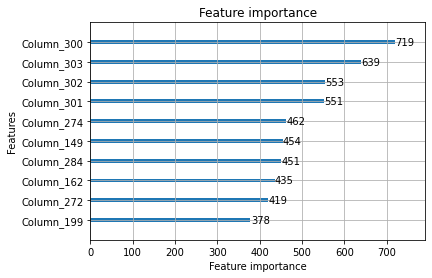

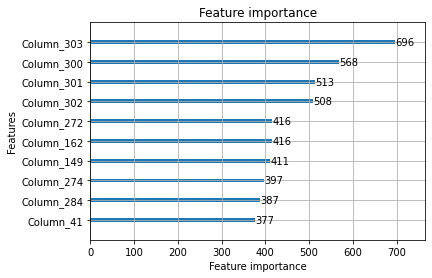

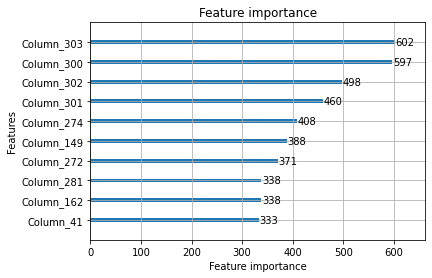

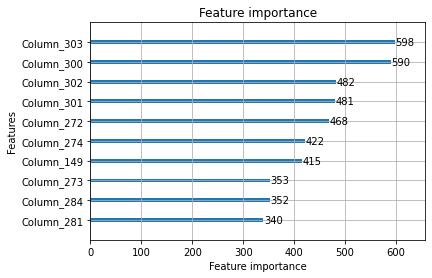

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
test_preds_1 = []
test_preds_2 = []

kf = StratifiedKFold(n_splits=5, random_state=seed, shuffle=True) # KFold

for fold, (train_idx, test_idx) in enumerate(kf.split(xtrain_norm, train_y)):
    X_train, X_test = xtrain_norm[train_idx], xtrain_norm[test_idx]
    y_train, y_test = train_y.iloc[train_idx], train_y.iloc[test_idx]
    train_dataset = lgb.Dataset(X_train, y_train)
    val_dataset = lgb.Dataset(X_test, y_test)
    model = lgb.train(params = lgbm_params, 
                    train_set = train_dataset, 
                    valid_sets = [train_dataset, val_dataset], 
                    num_boost_round = 5000, 
                    callbacks=[lgb.early_stopping(stopping_rounds=100)],
                    verbose_eval = 100)
    y_pred = model.predict(X_test).squeeze()
    classes = np.argmax(y_pred, axis = 1)
    valid_acc = np.mean(classes == y_test)
    confmat = confusion_matrix(classes, y_test)
    print(valid_acc)
    print(confmat)
    test_preds_1.append(model.predict(xtrain_norm).squeeze())
    test_preds_2.append(model.predict(test_norm).squeeze())
    lgb.plot_importance(model,max_num_features=10)

In [ ]:
from mlxtend.evaluate import confusion_matrix
predictions = sum(test_preds_1)/5
classes = np.argmax(predictions, axis = 1)
print(classes)
y_true = train_y.squeeze()
confmat = confusion_matrix(y_true, classes)

print(confmat)

[2 0 0 ... 0 0 0]
[[39138   421  8554]
 [18367   991  8293]
 [17332   424 17418]]


In [ ]:
train_acc = np.mean(classes == y_true)*100
train_acc

51.87311831833997

In [ ]:
prediction_1 = sum(test_preds_2)/5
prediction_1

array([[0.44944573, 0.30887058, 0.24168369],
       [0.35876696, 0.3254579 , 0.31577514],
       [0.38345919, 0.30927321, 0.3072676 ],
       ...,
       [0.2084595 , 0.27877897, 0.51276153],
       [0.60039663, 0.24317981, 0.15642356],
       [0.36293106, 0.29408705, 0.34298189]])

In [ ]:
!pip install --upgrade xgboost

In [ ]:
from sklearn.model_selection import KFold, StratifiedKFold
import xgboost as xgb
test_preds_1 = []
test_preds_3 = []

kf = StratifiedKFold(n_splits=5, random_state=123, shuffle=True) # KFold
i=0
for fold, (train_idx, test_idx) in enumerate(kf.split(xtrain_norm, train_y)):
    i=i+1
    print(i)
    X_train, X_test = xtrain_norm[train_idx], xtrain_norm[test_idx]
    y_train, y_test = train_y.iloc[train_idx], train_y.iloc[test_idx]
    model = xgb.XGBClassifier()
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    valid_acc = np.mean(y_pred == y_test)*100
    confmat = confusion_matrix(y_pred, y_test)
    print(valid_acc)
    print(confmat)
    test_preds_1.append(model.predict_proba(xtrain_norm).squeeze())
    test_preds_3.append(model.predict_proba(test_norm).squeeze())

1
49.409590769785474
[[7309 3470 3376]
 [ 450  387  392]
 [1864 1673 3267]]
2
49.10311880295655
[[7262 3551 3433]
 [ 389  356  325]
 [1972 1623 3277]]
3
49.13466738777718
[[7235 3450 3354]
 [ 458  375  389]
 [1929 1706 3292]]
4
48.93856762969306
[[7241 3425 3427]
 [ 466  390  381]
 [1915 1715 3227]]
5
48.699689007076216
[[7303 3486 3496]
 [ 459  359  395]
 [1861 1685 3143]]


In [ ]:
from mlxtend.evaluate import confusion_matrix
predictions = sum(test_preds_1)/5
classes = np.argmax(predictions, axis = 1)
print(classes)
y_true = train_y.squeeze()
confmat = confusion_matrix(y_true, classes)

print(confmat)

[2 0 2 ... 1 0 0]
[[42421   259  5433]
 [15366  5814  6471]
 [12980   365 21829]]


In [ ]:
train_acc = np.mean(classes == y_true)*100
train_acc

63.15599704339361

In [ ]:
prediction_2 = sum(test_preds_3)/5
prediction_2

array([[0.42552224, 0.32397112, 0.25050658],
       [0.36555204, 0.31960824, 0.31483975],
       [0.3499853 , 0.3561719 , 0.2938428 ],
       ...,
       [0.13650794, 0.24840207, 0.61509   ],
       [0.5540945 , 0.28754282, 0.15836272],
       [0.32603976, 0.3033595 , 0.37060076]], dtype=float32)

In [ ]:
w_lgbm = .7
w_xgb = .3
prediction_lgbm = pd.DataFrame(prediction_1,columns=['home', 'draw', 'away'])
prediction_xgb = pd.DataFrame(prediction_2,columns=['home', 'draw', 'away'])
prediction_final = pd.DataFrame(columns=['home', 'draw', 'away'])
prediction_final['home'] = prediction_lgbm['home']*w_lgbm+prediction_xgb['home']*w_xgb
prediction_final['draw'] = prediction_lgbm['draw']*w_lgbm+prediction_xgb['draw']*w_xgb
prediction_final['away'] = prediction_lgbm['away']*w_lgbm+prediction_xgb['away']*w_xgb

In [ ]:
submission = pd.concat([pd.DataFrame(testn['id']), pd.DataFrame(prediction_final, columns=['home', 'draw', 'away'])[['home', 'draw', 'away']]], axis=1)
submission.to_csv('/content/drive/MyDrive/7313Project/submission_ensemble.csv', index=False)